Example fitting a RHESSI observation of an M flare from [Flecther et. 2007](https://doi.org/10.1086/510446), flare #3 M1.2 (old GOES/XRS scaling). This flare has attenuator (A1) in during the flare and pre-flare background time - which is unusual and so background selection/subtraction is more like a shutter out flare.

* files generated by [get_fl20021005_a1.pro](https://github.com/ianan/sks_examples/blob/main/get_fl20021005_a1.pro)
* sunkit-spex simulatenous fit to individual detectors [sks_fit_rhessi_flare_simdets.ipynb](https://github.com/ianan/sks_examples/blob/main/sks_fit_rhessi_flare_simdets.ipynb)

Here the data is summed over detectors 1,3,4,6,8,9

* 27-Oct-2025   IGH
---

In [1]:
from astropy.time import Time, TimeDelta
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sunpy.io.special import read_genx

# Works with legacy code in sunkit-sepx version 0.4.1.dev52
from sunkit_spex.extern.rhessi import RhessiLoader
from sunkit_spex.legacy.fitting.fitter import Fitter

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

plt.rcParams.update({'font.size': 18,'mathtext.default':"regular"})

In [2]:
# Use the better fit models?
from sunkit_spex.legacy import thermal
ch_dir='../fvth_stuff/better_chxdb/'
# Or from https://github.com/ianan/fvth_stuff/tree/main/better_chxdb
thermal.LINE_GRID=thermal.setup_line_parameters(ch_dir+'chianti_lines_2_12_unity_v1102_t101.sav') 
thermal.CONTINUUM_GRID=thermal.setup_continuum_parameters(ch_dir+'chianti_cont_1_250_unity_v1102_t101.sav')

In [3]:
# Some setup for sunxspex
time_profile_size = (9,6)
spec_single_plot_size = (6,8)
spec_plot_size = (16,10)
spec_font_size = 18
default_font_size = 10
xlims, ylims = [3,100], [5e-2,3e4]
tol = 1e-5

# Where are the spec and srm fits files ???
_dir = "fits/"
specname=_dir+"20021005_103800_spec_sum.fits"
srmname=_dir+"20021005_103800_srm_sum.fits"
tmk2kev=0.086164

In [4]:
# Flare peak and background times
ftims=Time(['2002-10-05T10:41:20.000','2002-10-05T10:42:24.000'],format='isot')
btims=Time(['2002-10-05T10:38:32.000','2002-10-05T10:40:32.000'],format='isot')
fname='20021005_103800_sum'
print(fname)

print(ftims)
print(btims)

20021005_103800_sum
['2002-10-05T10:41:20.000' '2002-10-05T10:42:24.000']
['2002-10-05T10:38:32.000' '2002-10-05T10:40:32.000']


In [5]:
rhess_spec = RhessiLoader(spectrum_fn=specname, srm_fn=srmname)

In [6]:
rhess_spec.update_background_times(btims[0],btims[1])
rhess_spec.update_event_times(ftims[0],ftims[1])

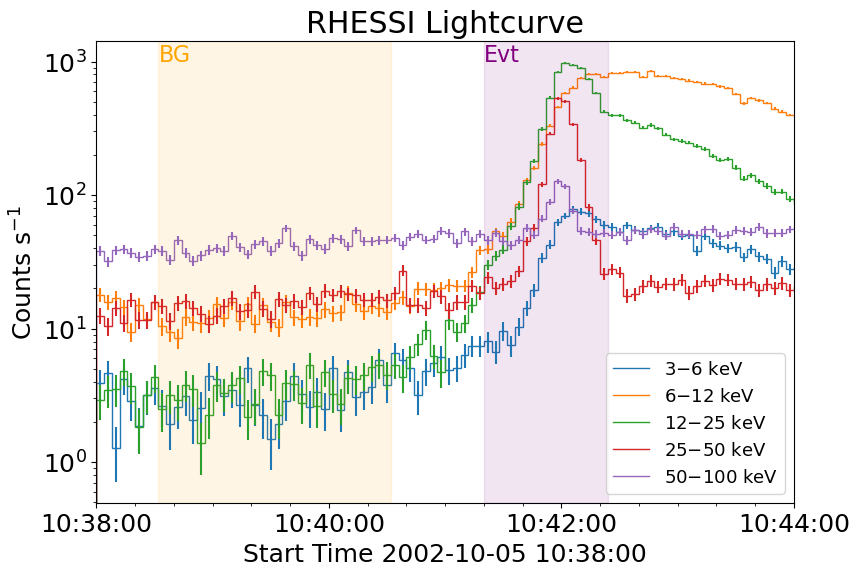

In [7]:
tr=Time(['2002-10-05T10:38:00.000','2002-10-05T10:44:00.000'],format='isot')
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=time_profile_size)
ax=rhess_spec.lightcurve(energy_ranges=[[3,6], [6,12], [12,25], [25,50],[50,100]])
ax.set_xlim(tr[0].datetime,tr[1].datetime)
ax.set_xlabel("Start Time "+tr[0].iso[:19])
ax.xaxis.set_minor_locator(matplotlib.dates.SecondLocator(interval=20))
ax.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(interval=2))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M:%S'))
plt.show()
plt.rcParams['font.size'] = default_font_size

In [8]:
#  Now do the fitting
fitter = Fitter(rhess_spec)
fitter.model = "(f_vth+thick_fn)"
fitter.loglikelihood = "cstat"
fitter.show_params

Param,Status,Value,Bounds,Error
,,,"(min, max)","(-, +)"
str22,str11,float64,object,object
T1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
EM1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
total_eflux1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
index1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
e_c1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
Fit Stat.,cstat ln(L),0.00e+00,--,--


In [9]:
# Fit setup and ranges optimised for this flare
# As A1 only fit > 6keV
fitter.energy_fitting_range = [6,15]
fitter.params["T1_spectrum1"] = {"Value":22, "Bounds":(10, 30)}
fitter.params["EM1_spectrum1"] = {"Value":10, "Bounds":(1e-1, 1e3)}
fitter.params["total_eflux1_spectrum1"] = {"Status":"fix", "Value":0.1, "Bounds":(1e-3, 1e2)}
fitter.params["index1_spectrum1"] = {"Status":"fix", "Value":6, "Bounds":(2, 12)}
fitter.params["e_c1_spectrum1"] = {"Status":"fix", "Value":20, "Bounds":(5, 30)}
spec_fit = fitter.fit()

# Then non-thermal fit higher energy
fitter.energy_fitting_range = [15,45]
fitter.params["T1_spectrum1"] = "fix"
fitter.params["EM1_spectrum1"] = "fix"
fitter.params["total_eflux1_spectrum1"] = "free"
fitter.params["index1_spectrum1"] = "free"
fitter.params["e_c1_spectrum1"] = "free"
spec_fit = fitter.fit()

# The do the full range
fitter.energy_fitting_range = [6,45]
fitter.params["T1_spectrum1"] = "free"
fitter.params["EM1_spectrum1"] = "free"
fitter.params["total_eflux1_spectrum1"] = "free"
fitter.params["index1_spectrum1"] = "free"
fitter.params["e_c1_spectrum1"] = "free"
spec_fit = fitter.fit()

# fitter.show_params
# fitted parameters
print(spec_fit)

[22.736184133833632, 19.926959882531584, 0.9831058534652766, 5.654804535530089, 19.827500418981423]


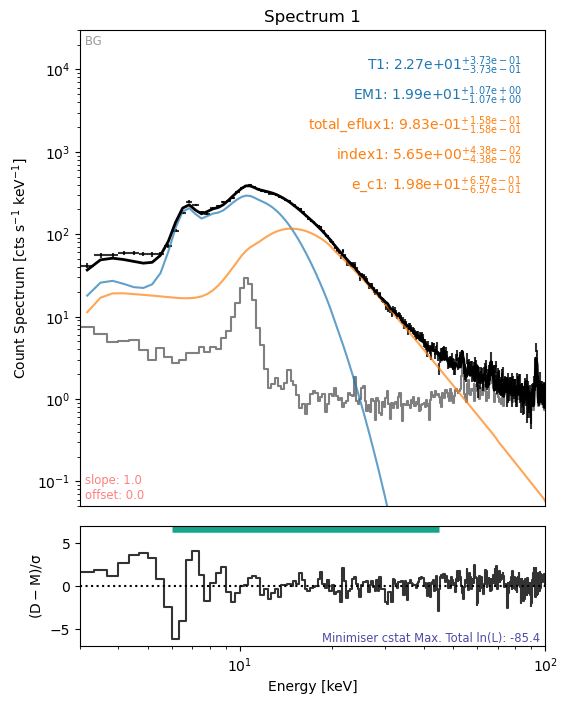

In [10]:
plt.figure(figsize=spec_single_plot_size)
axes, res_axes = fitter.plot()
for a in axes:
    a.set_xlim(xlims)
    a.set_ylim(ylims)
    a.set_xscale("log")
plt.show()

In [11]:
# Now do the mcmc
mcmc_result = fitter.run_mcmc(steps_per_walker=1000,walker_spread='mag_order')

100%|██████████| 1000/1000 [02:28<00:00,  6.76it/s]


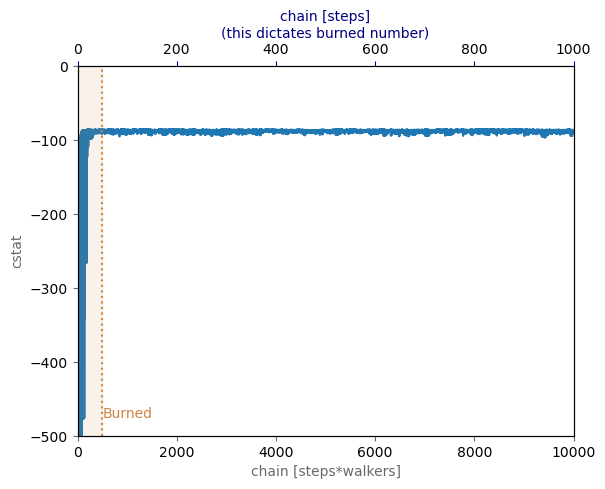

In [12]:
# Look at the log probability to see if enough runs to get stable solution
# Get rid of/burn the first 50 runs in this case
fitter.burn_mcmc = 50
plt.figure()
fitter.plot_log_prob_chain()
plt.ylim([-500,0])
plt.show()

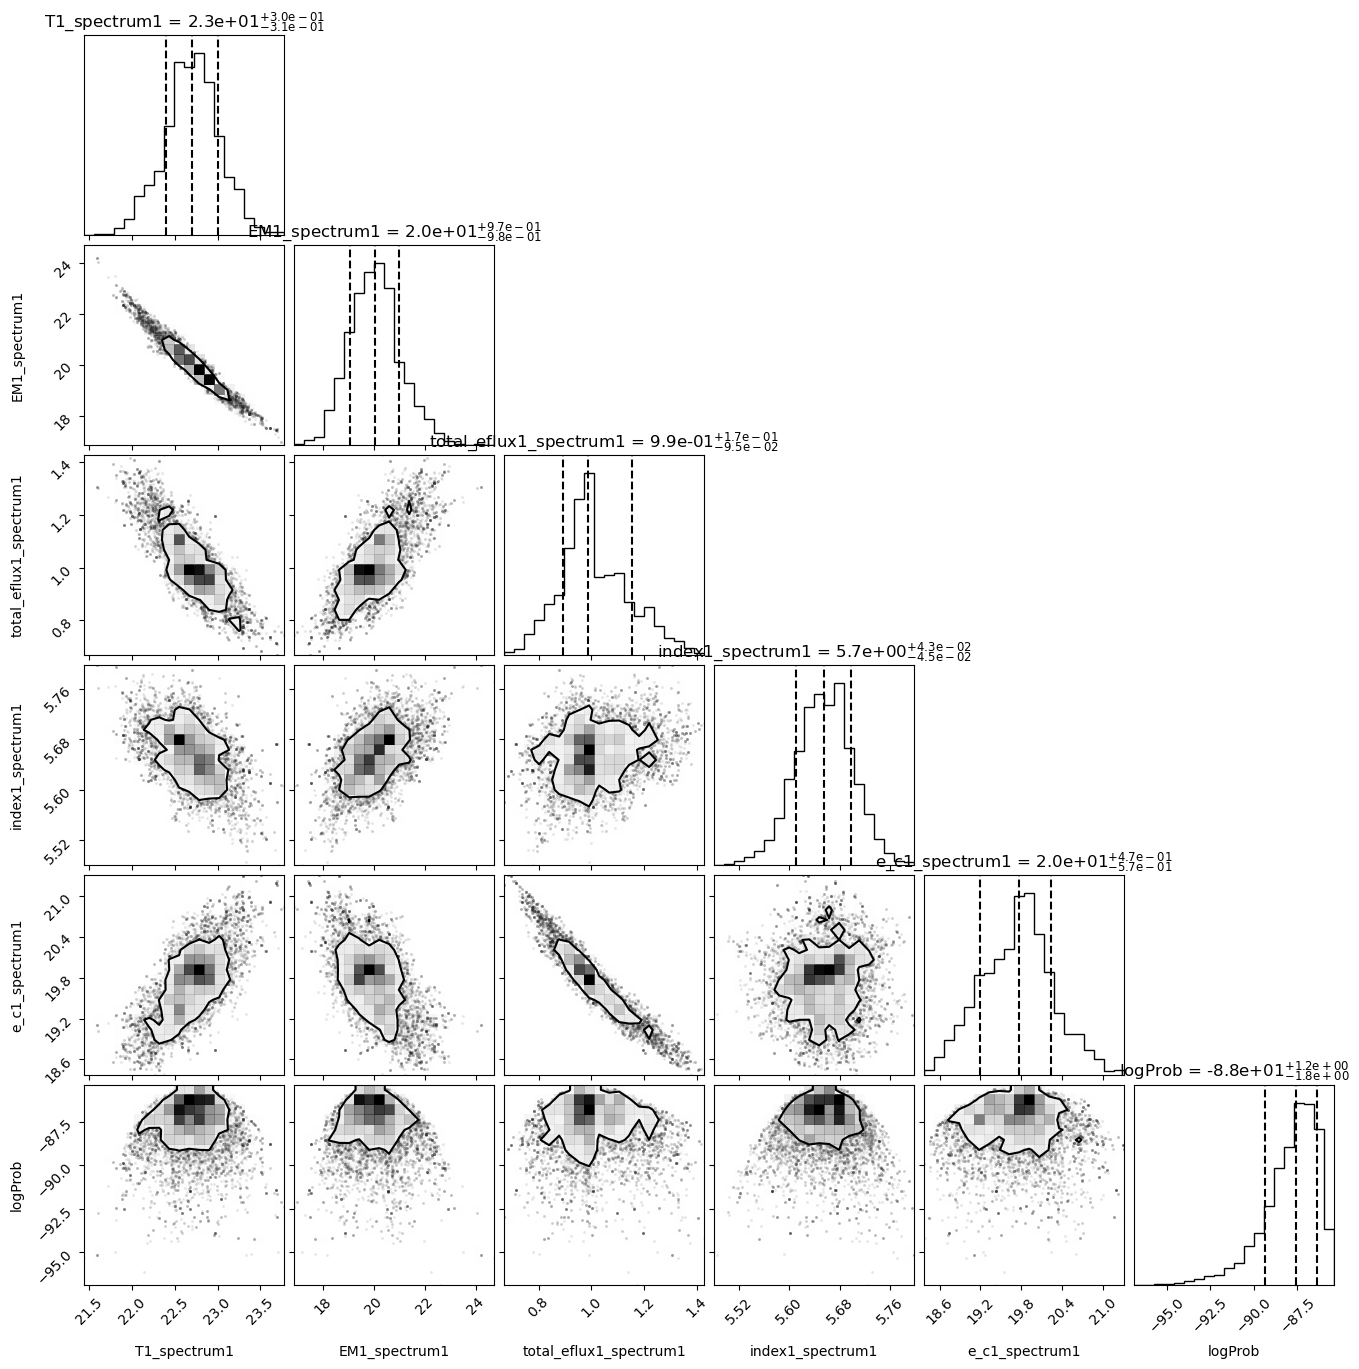

In [13]:
# Look at the results via the corner plot
corner_plot = fitter.corner_mcmc()

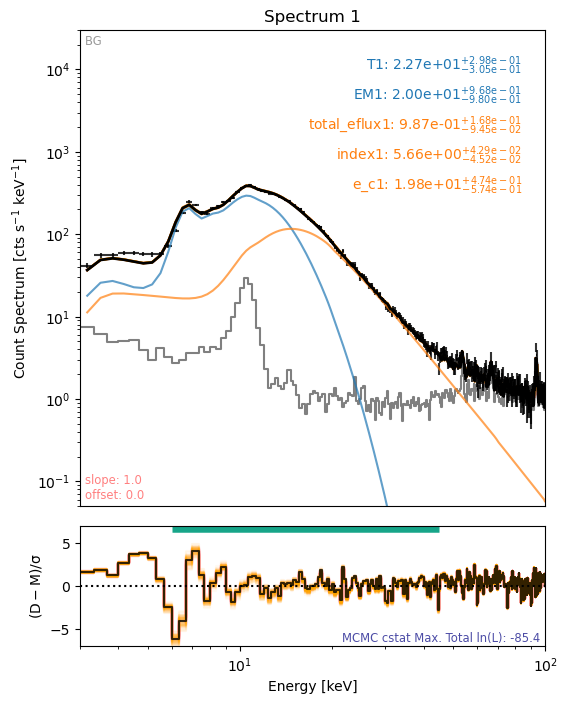

In [14]:
# Plot the spectrum using the mcmc fit results
plt.figure(figsize=spec_single_plot_size)
axes, res_axes = fitter.plot()
for a in axes:
    a.set_xlim(xlims)
    a.set_ylim(ylims)
    a.set_xscale("log")
plt.show()

In [15]:
# Also get the MC runs, this only exists once the default plot made (above)
mcs=fitter.plotting_info['spectrum1']['mcmc_model_runs']

In [16]:
# Let's extract all the info and make a nicer plot
# Note this only work in the current version of sunxspex.....
# Get all the fit parameters
tmk=fitter.params["T1_spectrum1"]['Value']
tmk_ci=[tmk-fitter.params["T1_spectrum1"]['Error'][0],tmk+fitter.params["T1_spectrum1"]['Error'][1]]
em=fitter.params["EM1_spectrum1"]['Value']*1e46
em_ci=[em-fitter.params["EM1_spectrum1"]['Error'][0]*1e46,\
    em+fitter.params["EM1_spectrum1"]['Error'][1]*1e46]
ntot=fitter.params["total_eflux1_spectrum1"]["Value"]*1e35
ntot_err=[fitter.params["total_eflux1_spectrum1"]["Error"][0]*1e35,\
          fitter.params["total_eflux1_spectrum1"]["Error"][1]*1e35]
ind=fitter.params["index1_spectrum1"]["Value"]
ind_err=[fitter.params["index1_spectrum1"]["Error"][0],fitter.params["index1_spectrum1"]["Error"][1]]
ec=fitter.params["e_c1_spectrum1"]["Value"]
ec_err=[fitter.params["e_c1_spectrum1"]["Error"][0],fitter.params["e_c1_spectrum1"]["Error"][1]]
# Make them look nice for the plot
tmks=f'{tmk:4.2f}'
tmkups=f'{tmk_ci[1]-tmk:4.2f}'
tmkdns=f'{tmk-tmk_ci[0]:4.2f}'
ems=f'{em*1e-46:4.2f}'
emups=f'{(em_ci[1]-em)*1e-46:4.2f}'
emdns=f'{(em-em_ci[0])*1e-46:4.2f}'
nts=f'{ntot*1e-35:4.2f}'
ntups=f'{ntot_err[1]*1e-35:4.2f}'
ntdns=f'{ntot_err[0]*1e-35:4.2f}'
inds=f'{ind:4.2f}'
indups=f'{ind_err[1]:4.2f}'
inddns=f'{ind_err[0]:4.2f}'
ecs=f'{ec:4.2f}'
ecups=f'{ec_err[1]:4.2f}'
ecdns=f'{ec_err[0]:4.2f}'
# Calculate the power
nnpow=1.6e-9*ntot*ec*(ind-1)/(ind-2)
nnpows=f'{nnpow*1e-27:4.2f}'
# Get the log likelihood
lnl=fitter._get_max_fit_stat()
lnls=f'{lnl:.2f}'
# Get the data and fits to replot
engs=fitter.plotting_info['spectrum1']['count_channels']
edels=fitter.plotting_info['spectrum1']['count_channel_error']
rat=fitter.plotting_info['spectrum1']['count_rates']
erat=fitter.plotting_info['spectrum1']['count_rate_errors']
# Currently background returns same values twice ?!?!?! like resid
backrat=fitter.plotting_info['spectrum1']['background_rate'][::2]
resid=fitter.plotting_info['spectrum1']['residuals'][::2]
fmd=fitter.plotting_info['spectrum1']['count_rate_model']
sfmd=fitter.plotting_info['spectrum1']['submodels']
fiter=fitter.plotting_info['spectrum1']['fitting_range']
# Sort out the energy binning steps for plotting
stepe = list()
for i in range(len(engs)):
    stepe.append(engs[i] - edels[i])
stepe.append(engs[-1]+edels[-1])
ns=len(stepe)

In [17]:
# # Now do a nicer plot
# plt.rcParams['font.size'] = 14
# yrlim=[-4,4]
# xlim=[3,100]
# ylim= [5e-2,5e3]
# gs_kw = dict(height_ratios=[4,1],hspace=0.02,wspace=0.05)
# fig, axs = plt.subplots(ncols=1, nrows=2, constrained_layout=False,
#                              gridspec_kw=gs_kw,figsize=(6,7))
# axs[0].step(stepe[0:ns-1],backrat,where='post',color='grey',lw=1.5,label='back')
# axs[0].errorbar(engs,rat,xerr=edels,yerr=erat,fmt='.',color='k',lw=1.,ms=2,label='flare+back')
# axs[0].step(stepe[0:ns-1],sfmd[0][0:ns-1],where='post',color='firebrick',label='fvth')
# axs[0].step(stepe[0:ns-1],sfmd[1][0:ns-1],where='post',color='royalblue',label='fthck2')
# axs[0].step(stepe[0:ns-1],fmd[0:ns-1],where='post',color='blueviolet',lw=2,label='fvth+fthck2+back')
# axs[0].legend(loc=3,labelcolor='linecolor',frameon=False,prop={'size': 12})
# axs[0].text(0.97,0.92,tmks+'$^{+'+tmkups+'}_{-'+tmkdns+'}$ MK, '+\
#             ems+'$^{+'+emups+'}_{-'+emdns+'}$x10$^{46}$ cm$^{-3}$',\
#               color='firebrick',ha='right',transform=axs[0].transAxes)
# axs[0].text(0.97,0.84,inds+'$^{+'+indups+'}_{-'+inddns+'}$, '+\
#             ecs+'$^{+'+ecups+'}_{-'+ecdns+'}$ keV, ',
#               color='royalblue',ha='right',transform=axs[0].transAxes)
# axs[0].text(0.97,0.76,nts+'$^{+'+ntups+'}_{-'+ntdns+'}$ x10$^{35}$ e$^{-}$s$^{-1}$',\
#               color='royalblue',ha='right',transform=axs[0].transAxes)
# axs[1].hlines(resid,stepe[0:-1],stepe[1:],color='rebeccapurple',lw=1.5)

# axs[0].set_ylabel('count s$^{-1}$ keV$^{-1}$')

# axs[0].set_ylabel('count s$^{-1}$ keV$^{-1}$')
# axs[0].set_xlabel(" ")
# axs[0].set_yscale("log")
# axs[0].set_ylim(ylim)


# axs[1].set_ylabel(r"(d-m)/$\sigma$")
# axs[1].set_ylim(yrlim)
# axs[1].set_xlabel("Energy [keV]")
# axs[1].hlines(0.0,xlims[0],xlims[1],color='grey',linestyle="--",alpha=0.7)
# axs[1].hlines(yrlim[1]*0.9,fiter[0],fiter[1],color='teal',lw=2)

# for aaxx in axs:
#     aaxx.set_xlim(xlim)
#     aaxx.set_xscale("log")
#     aaxx.set_xticks([4,6,10,20,30,50,100])
#     aaxx.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# axs[0].set_xticklabels([])
# plt.show()

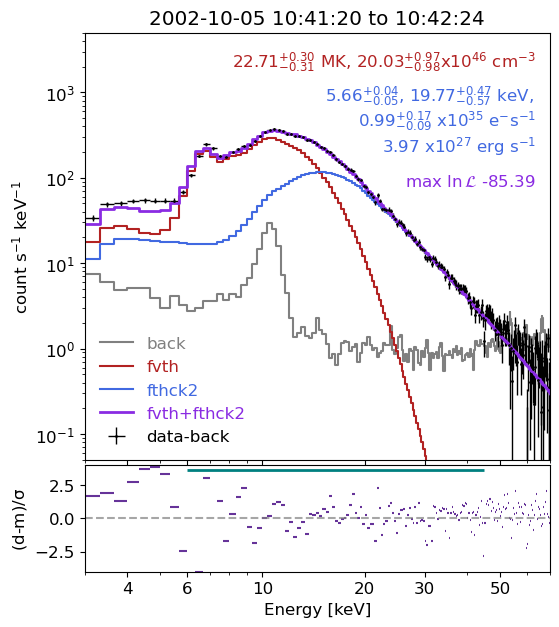

In [18]:
# Do the more standard plot of data-background
yrlim=[-4,4]
ylim=[5e-2,5e3]
xlim=[3,70]
plt.rcParams['font.size'] = 12
gs_kw = dict(height_ratios=[4,1],hspace=0.02,wspace=0.05)
fig, axs = plt.subplots(ncols=1, nrows=2, constrained_layout=False,
                             gridspec_kw=gs_kw,figsize=(6,7))
axs[0].step(stepe[0:ns-1],backrat,where='post',color='grey',lw=1.5,label='back')
axs[0].errorbar(engs,rat-backrat,xerr=edels,yerr=erat,fmt='.',color='k',lw=1.,ms=2,label='data-back')
axs[0].step(stepe[0:ns-1],sfmd[0][0:ns-1],where='post',color='firebrick',label='fvth')
axs[0].step(stepe[0:ns-1],sfmd[1][0:ns-1],where='post',color='royalblue',label='fthck2')
axs[0].step(stepe[0:ns-1],sfmd[0][0:ns-1]+sfmd[1][0:ns-1],where='post',color='blueviolet',lw=2,label='fvth+fthck2')
axs[0].legend(loc=3,labelcolor='linecolor',frameon=False,prop={'size': 12})
axs[0].text(0.97,0.92,tmks+'$^{+'+tmkups+'}_{-'+tmkdns+'}$ MK, '+\
            ems+'$^{+'+emups+'}_{-'+emdns+'}$x10$^{46}$ cm$^{-3}$',\
              color='firebrick',ha='right',transform=axs[0].transAxes)
axs[0].text(0.97,0.84,inds+'$^{+'+indups+'}_{-'+inddns+'}$, '+\
            ecs+'$^{+'+ecups+'}_{-'+ecdns+'}$ keV, ',
              color='royalblue',ha='right',transform=axs[0].transAxes)
axs[0].text(0.97,0.78,nts+'$^{+'+ntups+'}_{-'+ntdns+'}$ x10$^{35}$ e$^{-}$s$^{-1}$',\
              color='royalblue',ha='right',transform=axs[0].transAxes)
axs[0].text(0.97,0.72,nnpows+' x10$^{27}$ erg s$\mathit{^{-1}}$',\
              color='royalblue',ha='right',transform=axs[0].transAxes)
axs[0].text(0.97,0.64,'max $\ln{\mathcal{L}}$ '+lnls,color='blueviolet',\
            transform=axs[0].transAxes,ha='right')

axs[1].hlines(resid,stepe[0:-1],stepe[1:],color='rebeccapurple',lw=1.5)

axs[0].set_ylabel('count s$^{-1}$ keV$^{-1}$')
axs[0].set_xlabel(" ")
axs[0].set_yscale("log")
axs[0].set_ylim(ylim)
axs[0].set_title(ftims.iso[0][:-4]+' to '+ftims.iso[1][11:-4])

axs[1].set_ylabel(r"(d-m)/$\sigma$")
axs[1].set_ylim(yrlim)
axs[1].set_xlabel("Energy [keV]")
axs[1].hlines(0.0,xlims[0],xlims[1],color='grey',linestyle="--",alpha=0.7)
axs[1].hlines(yrlim[1]*0.9,fiter[0],fiter[1],color='teal',lw=2)

for aaxx in axs:
    aaxx.set_xlim(xlim)
    aaxx.set_xscale("log")
    aaxx.set_xticks([4,6,10,20,30,50])
    aaxx.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_xticklabels([])
# plt.savefig('nice_plot.pdf',bbox_inches='tight')
plt.show()

In [19]:
# # Data-background plot but with some of the MCMC runs
# yrlim=[-4,4]
# ylim=[5e-2,5e3]
# xlim=[3,70]
# plt.rcParams['font.size'] = 12
# gs_kw = dict(height_ratios=[4,1],hspace=0.02,wspace=0.05)
# fig, axs = plt.subplots(ncols=1, nrows=2, constrained_layout=False,
#                              gridspec_kw=gs_kw,figsize=(6,7))
# axs[0].step(stepe[0:ns-1],backrat,where='post',color='grey',lw=1.5,label='back')
# axs[0].errorbar(engs,rat-backrat,xerr=edels,yerr=erat,fmt='.',color='k',lw=1.,ms=2,label='data-back')
# axs[0].step(stepe[0:ns-1],sfmd[0][0:ns-1],where='post',color='firebrick',label='fvth')
# axs[0].step(stepe[0:ns-1],sfmd[1][0:ns-1],where='post',color='royalblue',label='fthck2')
# # axs[0].step(stepe[0:ns-1],sfmd[0][0:ns-1]+sfmd[1][0:ns-1],where='post',color='blueviolet',lw=2,label='fvth+fthck2')
# for mc in mcs[0]:
#     axs[0].step(stepe[0:ns-1],mc[0:ns-1]-backrat[0:ns-1],where='post',color='blueviolet',lw=0.5)
# axs[0].legend(loc=3,labelcolor='linecolor',frameon=False,prop={'size': 12})
# axs[0].text(0.97,0.92,tmks+'$^{+'+tmkups+'}_{-'+tmkdns+'}$ MK, '+\
#             ems+'$^{+'+emups+'}_{-'+emdns+'}$x10$^{46}$ cm$^{-3}$',\
#               color='firebrick',ha='right',transform=axs[0].transAxes)
# axs[0].text(0.97,0.84,inds+'$^{+'+indups+'}_{-'+inddns+'}$, '+\
#             ecs+'$^{+'+ecups+'}_{-'+ecdns+'}$ keV, ',
#               color='royalblue',ha='right',transform=axs[0].transAxes)
# axs[0].text(0.97,0.78,nts+'$^{+'+ntups+'}_{-'+ntdns+'}$ x10$^{35}$ e$^{-}$s$^{-1}$',\
#               color='royalblue',ha='right',transform=axs[0].transAxes)
# axs[0].text(0.97,0.72,nnpows+' x10$^{27}$ erg s$\mathit{^{-1}}$',\
#               color='royalblue',ha='right',transform=axs[0].transAxes)
# axs[0].text(0.97,0.64,'max $\ln{\mathcal{L}}$ '+lnls,color='blueviolet',\
#             transform=axs[0].transAxes,ha='right')

# axs[1].hlines(resid,stepe[0:-1],stepe[1:],color='rebeccapurple',lw=1.5)

# axs[0].set_ylabel('count s$^{-1}$ keV$^{-1}$')
# axs[0].set_xlabel(" ")
# axs[0].set_yscale("log")
# axs[0].set_ylim(ylim)
# axs[0].set_title(ftims.iso[0][:-4]+' to '+ftims.iso[1][11:-4])

# axs[1].set_ylabel(r"(d-m)/$\sigma$")
# axs[1].set_ylim(yrlim)
# axs[1].set_xlabel("Energy [keV]")
# axs[1].hlines(0.0,xlims[0],xlims[1],color='grey',linestyle="--",alpha=0.7)
# axs[1].hlines(yrlim[1]*0.9,fiter[0],fiter[1],color='teal',lw=2)

# for aaxx in axs:
#     aaxx.set_xlim(xlim)
#     aaxx.set_xscale("log")
#     aaxx.set_xticks([4,6,10,20,30,50])
#     aaxx.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# axs[0].set_xticklabels([])
# plt.show()